In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import mutual_info_regression
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("database.csv", low_memory=False)
print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (38113, 81)


,Vehicle ID,Year,Make,Model,Class,Drive,Transmission,Transmission Descriptor,Engine Index,Engine Descriptor,...,Hours to Charge (AC 240V),Composite City MPG,Composite Highway MPG,Composite Combined MPG,Range (FT1),City Range (FT1),Highway Range (FT1),Range (FT2),City Range (FT2),Highway Range (FT2)
0,26587,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,NaN,Manual 5-Speed,NaN,9001,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
1,27705,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,NaN,Manual 5-Speed,NaN,9005,(FFS) CA model,...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
2,26561,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,NaN,Manual 5-Speed,NaN,9002,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
3,27681,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,NaN,Manual 5-Speed,NaN,9006,(FFS) CA model,...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
4,27550,1984,AM General,DJ Po Vehicle 2WD,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,NaN,1830,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0


In [3]:
df.info()

missing_pct = (df.isnull().sum().sort_values(ascending=False) / len(df) * 100).round(2)
missing_pct.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38113 entries, 0 to 38112
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Vehicle ID                           38113 non-null  int64  
 1   Year                                 38113 non-null  int64  
 2   Make                                 38113 non-null  object 
 3   Model                                38113 non-null  object 
 4   Class                                38113 non-null  object 
 5   Drive                                36924 non-null  object 
 6   Transmission                         38102 non-null  object 
 7   Transmission Descriptor              15045 non-null  object 
 8   Engine Index                         38113 non-null  int64  
 9   Engine Descriptor                    22693 non-null  object 
 10  Engine Cylinders                     37977 non-null  float64
 11  Engine Displacement         

Alternate Charger              99.88
Vehicle Charger                99.87
Electric Motor                 98.42
Supercharger                   98.18
Range (FT2)                    96.24
Fuel Type 2                    96.23
Gas Guzzler Tax                93.98
Alternative Fuel/Technology    92.01
Turbocharger                   86.25
Start Stop Technology          83.10
Manufacturer Code              80.80
Transmission Descriptor        60.53
Engine Descriptor              40.46
Drive                           3.12
Engine Cylinders                0.36
Engine Displacement             0.35
Transmission                    0.03
GHG Score (Alt Fuel)            0.00
2D Luggage Volume               0.00
2D Passenger Volume             0.00
dtype: float64

In [4]:
#inspect unique fuel types
df["Fuel Type"].unique()

array(['Regular', 'Diesel', 'Premium', 'CNG', 'Electricity',
       'Gasoline or natural gas', 'Gasoline or E85',
       'Gasoline or propane', 'Premium or E85',
       'Premium Gas or Electricity', 'Midgrade',
       'Regular Gas and Electricity', 'Premium and Electricity',
       'Regular Gas or Electricity'], dtype=object)

In [5]:
#simplify fuel type
fuel_gas = {
    "Regular", "Premium", "Midgrade", "Diesel", "CNG",
    "Gasoline or natural gas", "Gasoline or E85", "Gasoline or propane",
    "Premium or E85"
}
fuel_hybrid = {
    "Premium Gas or Electricity", "Regular Gas and Electricity",
    "Premium and Electricity", "Regular Gas or Electricity"
}

df = df.copy()

df.loc[df["Fuel Type"].isin(fuel_gas), "Fuel Type"] = "Gas"
df.loc[df["Fuel Type"].isin(fuel_hybrid), "Fuel Type"] = "Hybrid"
df.loc[df["Fuel Type"].eq("Electricity"), "Fuel Type"] = "Electric"

df["Fuel Type"].unique()

array(['Gas', 'Electric', 'Hybrid'], dtype=object)

In [6]:
#simplify drive
drive_4 = {
    "4-Wheel or All-Wheel Drive", "4-Wheel Drive",
    "All-Wheel Drive", "Part-time 4-Wheel Drive"
}
drive_2 = {"2-Wheel Drive", "Front-Wheel Drive", "Rear-Wheel Drive"}

df.loc[df["Drive"].isin(drive_4), "Drive"] = "4-Wheel or All-Wheel Drive"
df.loc[df["Drive"].isin(drive_2), "Drive"] = "2-Wheel Drive"

# fill missing 'Drive' with the mode (most frequent)
if df["Drive"].isna().any():
    df["Drive"] = df["Drive"].fillna(df["Drive"].mode()[0])

df["Drive"].unique()

array(['2-Wheel Drive', '4-Wheel or All-Wheel Drive'], dtype=object)

In [7]:
#drop columns
cols_to_drop = [
    "Alternate Charger", "Vehicle Charger", "Electric Motor",
    "Supercharger", "Range (FT2)", "Fuel Type 2", "Gas Guzzler Tax",
    "Alternative Fuel/Technology", "Turbocharger", "Start Stop Technology",
    "Manufacturer Code", "Transmission Descriptor", "Engine Descriptor"
]

df = df.drop(columns=cols_to_drop, errors="ignore")
df.shape

(38113, 68)

In [8]:
#fill NaNs w/ most common value per column
for col in df.columns:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

#verify nothing important missing
df.isnull().sum().head(20)

Vehicle ID                        0
Year                              0
Make                              0
Model                             0
Class                             0
Drive                             0
Transmission                      0
Engine Index                      0
Engine Cylinders                  0
Engine Displacement               0
Fuel Type                         0
Fuel Type 1                       0
City MPG (FT1)                    0
Unrounded City MPG (FT1)          0
City MPG (FT2)                    0
Unrounded City MPG (FT2)          0
City Gasoline Consumption (CD)    0
City Electricity Consumption      0
City Utility Factor               0
Highway MPG (FT1)                 0
dtype: int64

In [9]:
df.head()

,Vehicle ID,Year,Make,Model,Class,Drive,Transmission,Engine Index,Engine Cylinders,Engine Displacement,...,Hours to Charge (240V),Hours to Charge (AC 240V),Composite City MPG,Composite Highway MPG,Composite Combined MPG,Range (FT1),City Range (FT1),Highway Range (FT1),City Range (FT2),Highway Range (FT2)
0,26587,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,2-Wheel Drive,Manual 5-Speed,9001,6.0,2.5,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
1,27705,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,2-Wheel Drive,Manual 5-Speed,9005,6.0,2.5,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
2,26561,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,2-Wheel Drive,Manual 5-Speed,9002,4.0,2.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
3,27681,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,2-Wheel Drive,Manual 5-Speed,9006,4.0,2.0,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0
4,27550,1984,AM General,DJ Po Vehicle 2WD,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,1830,4.0,2.5,...,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0


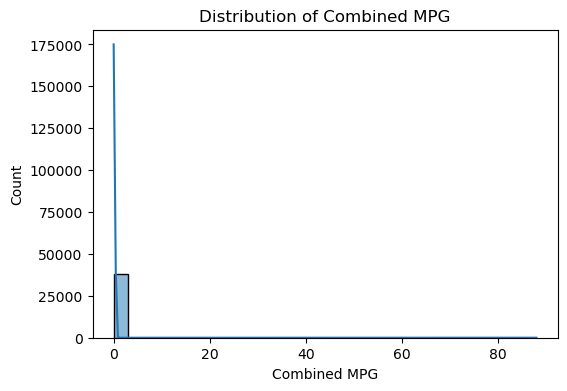

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df['Composite Combined MPG'], bins=30, kde=True)
plt.title('Distribution of Combined MPG')
plt.xlabel('Combined MPG')
plt.ylabel('Count')
plt.show()

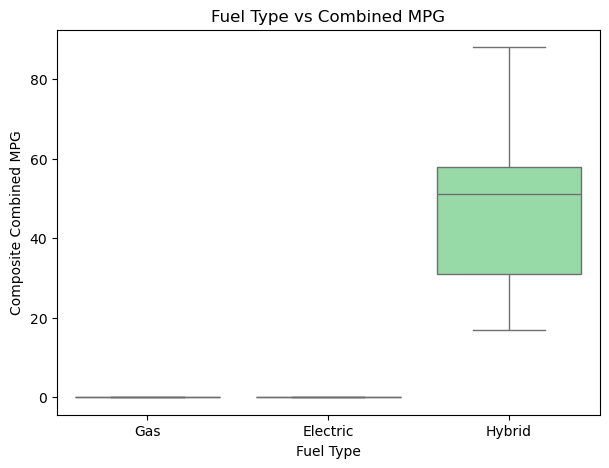

In [11]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Fuel Type', y='Composite Combined MPG', palette='pastel')
plt.title('Fuel Type vs Combined MPG')
plt.show()

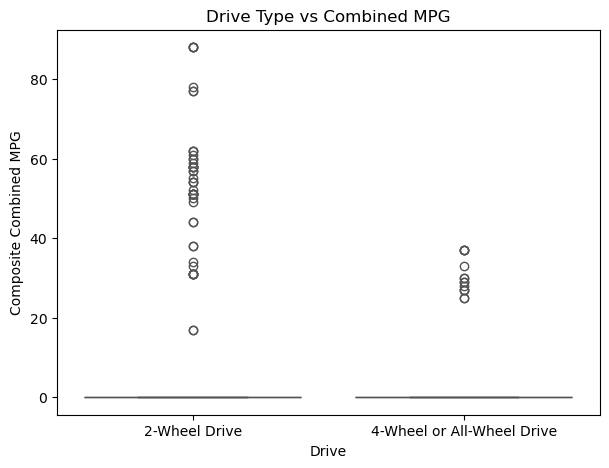

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Drive', y='Composite Combined MPG', palette='muted')
plt.title('Drive Type vs Combined MPG')
plt.show()

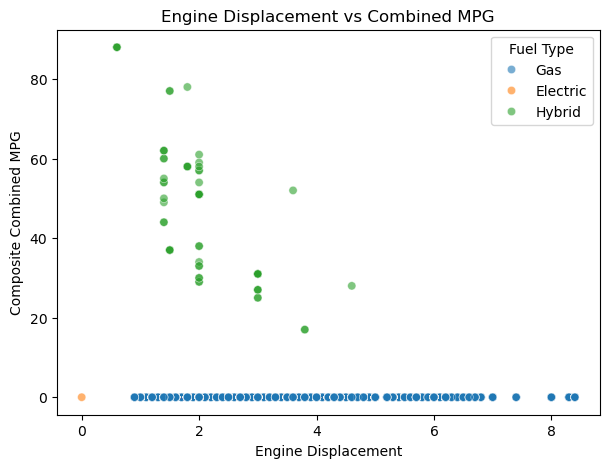

In [13]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Engine Displacement', y='Composite Combined MPG', hue='Fuel Type', alpha=0.6)
plt.title('Engine Displacement vs Combined MPG')
plt.show()

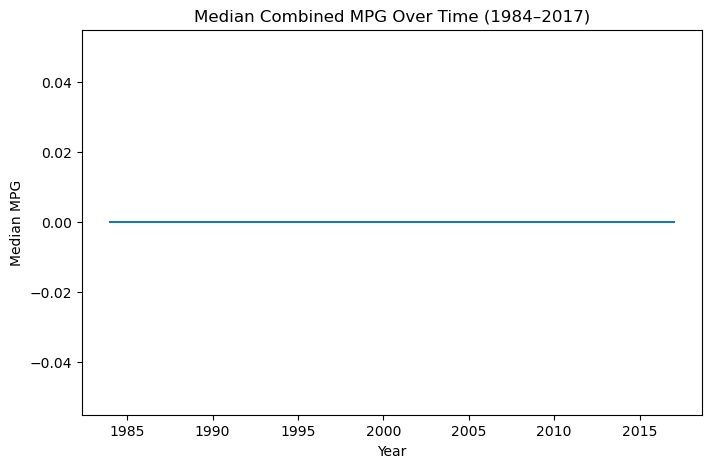

In [14]:
plt.figure(figsize=(8,5))
yearly = df.groupby('Year')['Composite Combined MPG'].median()
sns.lineplot(x=yearly.index, y=yearly.values)
plt.title('Median Combined MPG Over Time (1984–2017)')
plt.xlabel('Year')
plt.ylabel('Median MPG')
plt.show()

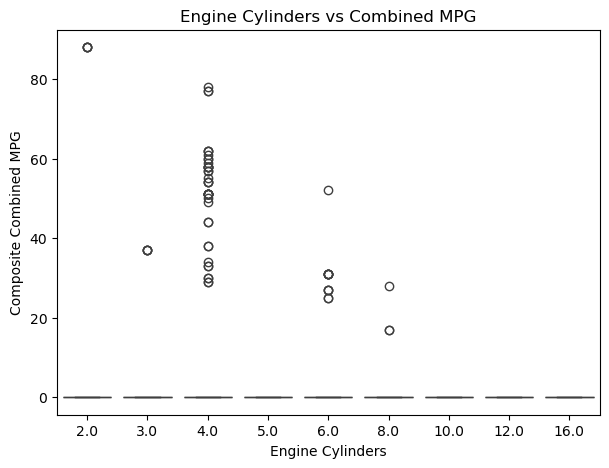

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Engine Cylinders', y='Composite Combined MPG')
plt.title('Engine Cylinders vs Combined MPG')
plt.show()

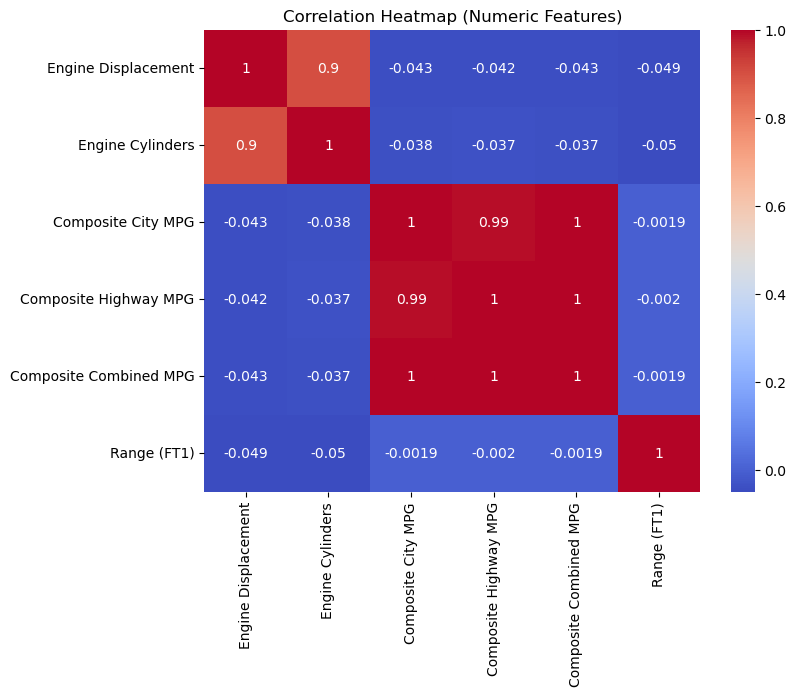

In [16]:
plt.figure(figsize=(8,6))
num_cols = ['Engine Displacement','Engine Cylinders',
            'Composite City MPG','Composite Highway MPG','Composite Combined MPG','Range (FT1)']
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

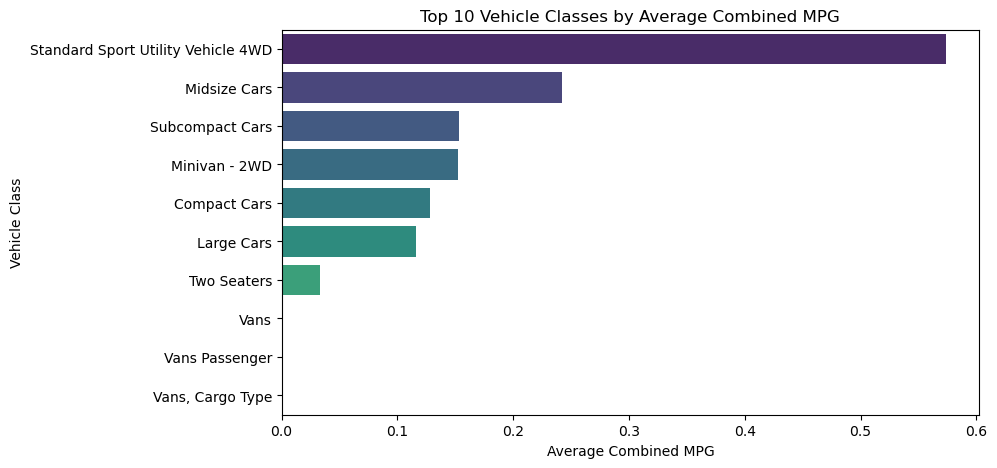

In [17]:
plt.figure(figsize=(9,5))
top_classes = df.groupby('Class')['Composite Combined MPG'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis')
plt.title('Top 10 Vehicle Classes by Average Combined MPG')
plt.xlabel('Average Combined MPG')
plt.ylabel('Vehicle Class')
plt.show()

In [18]:
missing_pct = df.isna().mean().sort_values(ascending=False)
print("Missing percentages (top 10):")
print(missing_pct.head(10))

#drop columns with more than 50% missing
drop_missing = missing_pct[missing_pct > 0.5].index.tolist()
print(f"Dropping {len(drop_missing)} columns with >50% missing values:", drop_missing)

df_cleaned = df.drop(columns=drop_missing)
print("After dropping missing columns:", df_cleaned.shape)

Missing percentages (top 10):
Vehicle ID                          0.0
Tailpipe CO2 in Grams/Mile (FT1)    0.0
My MPG Data                         0.0
GHG Score (Alt Fuel)                0.0
GHG Score                           0.0
Fuel Economy Score                  0.0
Tailpipe CO2 in Grams/Mile (FT2)    0.0
Tailpipe CO2 (FT2)                  0.0
Tailpipe CO2 (FT1)                  0.0
Year                                0.0
dtype: float64
Dropping 0 columns with >50% missing values: []
After dropping missing columns: (38113, 68)


In [26]:
target = "Composite Combined MPG"

# Split features and target
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target].copy()

initial_feature_count = X.shape[1]
print("Initial feature count:", X.shape[1])

Initial feature count: 67


In [20]:
# Drop near-constant columns (no variation)
low_var = [c for c in X.columns if X[c].nunique() <= 1]
if low_var:
    print("Dropping low-variance features:", low_var)
    X = X.drop(columns=low_var)

# Drop duplicate columns (exact same values)
X = X.loc[:, ~X.T.duplicated()]
print("After dropping constants/duplicates:", X.shape[1])

Dropping low-variance features: ['Hours to Charge (120V)']
After dropping constants/duplicates: 66


In [21]:
#Remove super correlated numeric features (|r| ≥ 0.85)
num_cols = X.select_dtypes(include=[np.number]).columns
corr_matrix = X[num_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))

high_corr = [col for col in upper.columns if any(upper[col] >= 0.85)]
if len(high_corr) > 0:
    X = X.drop(columns=high_corr)
    num_cols = [c for c in num_cols if c not in high_corr]

print("After high-corr drop:", X.shape[1])

After high-corr drop: 29


In [29]:
#Numeric Correlation + Mutual Info for Categoricals
num_corr = X[num_cols].corrwith(y).abs()
num_keep = num_corr[num_corr >= 0.05].sort_values(ascending=False)

cat_cols = X.select_dtypes(exclude=[np.number]).columns
if len(cat_cols) > 0:
    dummies = pd.get_dummies(X[cat_cols], drop_first=True)
    if dummies.shape[1] > 0:
        mi_vals = mutual_info_regression(dummies, y, random_state=0)
        mi = pd.Series(mi_vals, index=dummies.columns)
        mi_grouped = mi.groupby(lambda s: s.split("_")[0]).max().sort_values(ascending=False)
    else:
        mi_grouped = pd.Series(dtype=float)
else:
    mi_grouped = pd.Series(dtype=float)

cat_keep = mi_grouped.head(10)


In [28]:
# Pick ≤ 20 features and show selection
selected = list(num_keep.index)
for col in cat_keep.index:
    if col not in selected:
        selected.append(col)

# Keep only top 20 features
if len(selected) > 20:
    selected = selected[:20]

final_feature_count = len(selected)
print("Final feature count:", final_feature_count)
print("Selected features:", selected)


Final feature count: 20
Selected features: ['City Utility Factor', 'City MPG (FT2)', 'City Electricity Consumption', 'Hours to Charge (240V)', 'Fuel Economy Score', 'City Gasoline Consumption (CD)', 'Unrounded City MPG (FT1)', 'City MPG (FT1)', 'Vehicle ID', 'Annual Fuel Cost (FT1)', 'Year', 'Fuel Type', 'Model', 'Make', 'Transmission', 'Gasoline/Electricity Blended (CD)', 'Class', 'Fuel Type 1', 'Drive', 'My MPG Data']


In [27]:
records = []
selected_set = set(selected)

for col in X.columns:
    if col in selected_set:
        reasons = []
        if col in num_corr.index:
            reasons.append(f"corr={num_corr[col]:.2f}")
        if col in cat_keep.index:
            reasons.append(f"MI={cat_keep[col]:.2f}")
        why = ", ".join(reasons) if reasons else "kept"
        preprocess = "scale" if col in num_cols else "encode"
        records.append({"Feature": col, "Keep?": "yes", "Why": why, "Preprocess": preprocess})
    else:
        records.append({"Feature": col, "Keep?": "no", "Why": "dropped in filters", "Preprocess": "-"})

summary = pd.DataFrame(records).sort_values(["Keep?", "Feature"], ascending=[False, True])
display(summary.head(20))
print(f"Before: {initial_feature_count} features → After: {final_feature_count}")

,Feature,Keep?,Why,Preprocess
37,Annual Fuel Cost (FT1),yes,corr=0.06,scale
17,City Electricity Consumption,yes,corr=0.49,scale
16,City Gasoline Consumption (CD),yes,corr=0.12,scale
12,City MPG (FT1),yes,corr=0.10,scale
14,City MPG (FT2),yes,corr=0.84,scale
18,City Utility Factor,yes,corr=0.98,scale
4,Class,yes,MI=0.01,encode
5,Drive,yes,MI=0.00,encode
46,Fuel Economy Score,yes,corr=0.14,scale
10,Fuel Type,yes,MI=0.02,encode


Before: 67 features → After: 20
